<a href="https://colab.research.google.com/github/RuslanKozlyak/BackgroundRemover/blob/master/VRP_ORIG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!git clone https://github.com/kevin-schumann/VRP-GYM.git

Cloning into 'VRP-GYM'...
remote: Enumerating objects: 461, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 461 (delta 36), reused 34 (delta 34), pack-reused 416
Receiving objects: 100% (461/461), 86.40 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (175/175), done.
Updating files: 100% (128/128), done.


In [37]:
%cd VRP-GYM

/content/VRP-GYM/VRP-GYM/VRP-GYM/VRP-GYM/VRP-GYM


# VRPGraph

In [38]:
import networkx as nx
import numpy as np


class VRPGraph:

    graph: nx.Graph = nx.Graph()

    def __init__(self, num_nodes: int, num_depots: int, plot_demand: bool = False):
        """
        Creates a fully connected graph with node_num nodes
        and depot num depots. Coordinates of each node
        and the depot nodes will be samples randomly.

        Args:
            node_num (int): Number of nodes in the graph.
            depot_num (int): Number of depots in the graph.
        """
        self.num_nodes = num_nodes
        self.num_depots = num_depots
        self.plot_demand = plot_demand

        # offset for node labels
        self.offset = offset = np.array([0, 0.065])

        # generate graph and set node position
        self.graph = nx.complete_graph(num_nodes)
        node_position = {
            i: coordinates for i, coordinates in enumerate(np.random.rand(num_nodes, 2))
        }
        nx.set_node_attributes(self.graph, node_position, "coordinates")

        # sample depots and set attributes
        self.depots = np.array([0])# np.random.choice(num_nodes, size=num_depots, replace=False)
        one_hot = np.zeros(num_nodes)
        one_hot[self.depots] = 1
        one_hot_dict = {i: depot for i, depot in enumerate(one_hot)}

        nx.set_node_attributes(self.graph, one_hot_dict, "depot")

        # set demand for each node except depots
        C = 0.2449 * num_nodes + 26.12  # linear reg on values from paper
        demand = np.random.uniform(low=1, high=10, size=(num_nodes, 1)) / C
        demand[self.depots] = 0
        node_demand = {i: d for i, d in enumerate(demand)}
        nx.set_node_attributes(self.graph, node_demand, "demand")

        self.set_default_node_attributes()

    def set_default_node_attributes(self):
        """
        Sets the default colors of the  nodes
        as attributes. Nodes are black except
        depots which are colored in red.

        Edges are initially marked as unvisited.
        """
        nx.set_edge_attributes(self.graph, False, "visited")
        nx.set_node_attributes(self.graph, "black", "node_color")
        for node in self.depots:
            self.graph.nodes[node]["node_color"] = "red"

    def draw(self, ax):
        """
        Draws the graph as a matplotlib plot.
        Depots are colored in red. Edges that have been
        traveresed
        """

        # draw nodes according to color and position attribute
        pos = nx.get_node_attributes(self.graph, "coordinates")
        node_colors = nx.get_node_attributes(self.graph, "node_color").values()
        nx.draw_networkx_nodes(
            self.graph, pos, node_color=node_colors, ax=ax, node_size=100
        )

        # draw edges that where visited
        edges = [x for x in self.graph.edges(data=True) if x[2]["visited"]]
        nx.draw_networkx_edges(
            self.graph,
            pos,
            alpha=0.5,
            edgelist=edges,
            edge_color="red",
            ax=ax,
            width=1.5,
        )

        # draw demand above the node

        if self.plot_demand:
            demand_label_pos = {k: (v + self.offset) for k, v in pos.items()}
            node_demand = nx.get_node_attributes(self.graph, "demand")
            node_demand = {k: np.round(v, 2)[0] for k, v in node_demand.items()}
            nx.draw_networkx_labels(
                self.graph, demand_label_pos, labels=node_demand, ax=ax
            )

    def visit_edge(self, source_node: int, target_node: int) -> None:
        """
        Sets the edge color to red.

        Args:
            source_node (int): Source node id of the edge
            target_node (int): Target node id of the edge
        """

        # don't draw self loops
        if source_node == target_node:
            return

        self.graph.edges[source_node, target_node]["visited"] = True

    @property
    def demand(self) -> np.ndarray:
        positions = nx.get_node_attributes(self.graph, "demand").values()
        return np.asarray(list(positions))

    @property
    def edges(self):
        return self.graph.edges.data()

    @property
    def nodes(self):
        return self.graph.nodes.data()

    @property
    def node_positions(self) -> np.ndarray:
        """
        Returns the coordinates of each node as
        an ndarray of shape (num_nodes, 2) sorted
        by the node index.
        """

        positions = nx.get_node_attributes(self.graph, "coordinates").values()
        return np.asarray(list(positions))

    def euclid_distance(self, node1_idx: int, node2_idx: int) -> float:
        """
        Calculates the euclid distance between two nodes
        with their idx's respectively.
        """

        node_one_pos = self.graph.nodes[node1_idx]["coordinates"]
        node_two_pos = self.graph.nodes[node2_idx]["coordinates"]

        return np.linalg.norm(node_one_pos - node_two_pos)

# VRPNetwork

In [39]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np


class VRPNetwork:
    def __init__(
        self,
        num_graphs: int,
        num_nodes: int,
        num_depots: int,
        plot_demand: bool = False,
    ) -> List[VRPGraph]:
        """
        Creates num_graphs random generated fully connected
        graphs with num_nodes nodes. Node positions are
        sampled uniformly in [0, 1]. In each graph
        num_debots nodes are marked as depots.

        Args:
            num_graphs (int): Number of graphs to generate.
            num_nodes (int): Number of nodes in each graph.
            num_depots (int): Number of depots in each graph.

        Returns:
            List[VRPGraph]: List of num_graphs networkx graphs
        """

        assert (
            num_nodes >= num_depots
        ), "Number of depots should be lower than number of depots"

        self.num_nodes = num_nodes
        self.num_depots = num_depots
        self.num_graphs = num_graphs
        self.graphs: List[VRPGraph] = []

        # generate a graph with nn nodes and nd depots
        for _ in range(num_graphs):
            self.graphs.append(VRPGraph(num_nodes, num_depots, plot_demand=plot_demand))

    def get_distance(self, graph_idx: int, node_idx_1: int, node_idx_2: int) -> float:
        """
        Calculates the euclid distance between the two nodes
        within a single graph in the VRPNetwork.

        Args:
            graph_idx (int): Index of the graph
            node_idx_1 (int): Source node
            node_idx_2 (int): Target node

        Returns:
            float: Euclid distance between the two nodes
        """
        return self.graphs[graph_idx].euclid_distance(node_idx_1, node_idx_2)

    def get_distances(self, paths) -> np.ndarray:
        """
        Calculatest the euclid distance between
        each node pair in paths.

        Args:
            paths (nd.array): Shape num_graphs x 2
                where the second dimension denotes
                [source_node, target_node].

        Returns:
            np.ndarray: Euclid distance between each
                node pair. Shape (num_graphs,)
        """
        return np.array(
            [
                self.get_distance(index, source, dest)
                for index, (source, dest) in enumerate(paths)
            ]
        )

    def get_depots(self) -> np.ndarray:
        """
        Get the depots of every graph within the network.

        Returns:
            np.ndarray: Returns nd.array of shape
                (num_graphs, num_depots).
        """

        depos_idx = np.zeros((self.num_graphs, self.num_depots), dtype=int)

        for i in range(self.num_graphs):
            depos_idx[i] = self.graphs[i].depots

        return depos_idx

    def get_demands(self) -> np.ndarray:
        """
        Returns the demands for each node in each graph.

        Returns:
            np.ndarray: Demands of each node in shape
                (num_graphs, num_nodes, 1)
        """
        demands = np.zeros(shape=(self.num_graphs, self.num_nodes, 1))
        for i in range(self.num_graphs):
            demands[i] = self.graphs[i].demand

        return demands

    def draw(self, graph_idxs: np.ndarray) -> None:
        """
        Draw multiple graphs in a matplotlib grid.

        Args:
            graph_idxs (np.ndarray): Idxs of graphs which get drawn.
                Expected to be of shape (x, ).

        Returns:
            np.ndarray: Plot as rgb-array of shape (width, height, 3).
        """

        num_columns = min(len(graph_idxs), 3)
        num_rows = np.ceil(len(graph_idxs) / num_columns).astype(int)

        # plot each graph in a 3 x num_rows grid
        plt.clf()
        fig = plt.figure(figsize=(5 * num_columns, 5 * num_rows))

        for n, graph_idx in enumerate(graph_idxs):
            ax = plt.subplot(num_rows, num_columns, n + 1)

            self.graphs[graph_idx].draw(ax=ax)

        plt.show()

        # convert to plot to rgb-array
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        return image

    def visit_edges(self, transition_matrix: np.ndarray) -> None:
        """
        Visits each edges specified in the transition matrix.

        Args:
            transition_matrix (np.ndarray): Shape num_graphs x 2
                where each row is [source_node_idx, target_node_idx].
        """
        for i, row in enumerate(transition_matrix):
            self.graphs[i].visit_edge(row[0], row[1])

    def get_graph_positions(self) -> np.ndarray:
        """
        Returns the coordinates of each node in every graph as
        an ndarray of shape (num_graphs, num_nodes, 2) sorted
        by the graph and node index.

        Returns:
            np.ndarray: Node coordinates of each graph. Shape
                (num_graphs, num_nodes, 2)
        """

        node_positions = np.zeros(shape=(len(self.graphs), self.num_nodes, 2))
        for i, graph in enumerate(self.graphs):
            node_positions[i] = graph.node_positions

        return node_positions

 # TSPEnv

In [40]:
from typing import Tuple, Union

import numpy as np
from gym import Env
from gym.wrappers.monitoring.video_recorder import VideoRecorder


class TSPEnv(Env):
    """
    TSPEnv implements the Traveling Salesmen Problem
    a special variant of the vehicle routing problem.

    State: Shape (batch_size, num_nodes, 4) The third
        dimension is structured as follows:
        [x_coord, y_coord, is_depot, visitable]

    Actions: Depends on the number of nodes in every graph.
        Should contain the node numbers to visit next for
        each graph. Shape (batch_size, 1)
    """

    metadata = {"render.modes": ["human", "rgb_array"]}

    def __init__(
        self,
        num_nodes: int = 20,
        batch_size: int = 128,
        num_draw: int = 6,
        seed: int = 69,
    ):
        """
        Args:
            num_nodes (int, optional): Number of nodes in each generated graph. Defaults to 32.
            batch_size (int, optional): Number of graphs to generate. Defaults to 128.
            num_draw (int, optional): When calling the render num_draw graphs will be rendered.
                Defaults to 6.
            seed (int, optional): Seed of the environment. Defaults to 69.
            video_save_path (str, optional): When set a video of the interactions with the
                environment is saved at the set location. Defaults to None.
        """
        assert (
            num_draw <= batch_size
        ), "Num_draw needs to be equal or lower than the number of generated graphs."

        np.random.seed(seed)

        self.step_count = 0
        self.num_nodes = num_nodes
        self.batch_size = batch_size

        # init video recorder
        self.draw_idxs = np.random.choice(batch_size, num_draw, replace=False)
        self.video_save_path = None

        self.generate_graphs()

    def step(self, actions: np.ndarray):
        """
        Run the environment one timestep. It's the users responsiblity to
        call reset() when the end of the episode has been reached. Accepts
        an actions and return a tuple of (observation, reward, done, info)

        Args:
            actions (nd.ndarray): Which node to visit for each graph.
                Shape of actions is (batch_size, 1).

        Returns:
            Tuple[ObsType, float, bool, dict]: Tuple of the observation,
                reward, done and info. The observation is within
                self.observation_space. The reward is for the previous action.
                If done equals True then the episode is over. Stepping through
                environment while done returns undefined results. Info contains
                may contain additions info in terms of metrics, state variables
                and such.
        """
        assert (
            actions.shape[0] == self.batch_size
        ), "Number of actions need to equal the number of generated graphs."

        self.step_count += 1

        # visit each next node
        self.visited[np.arange(len(actions)), actions.T] = 1
        traversed_edges = np.hstack([self.current_location, actions]).astype(int)
        self.sampler.visit_edges(traversed_edges)

        self.current_location = np.array(actions)

        if self.video_save_path is not None:
            self.vid.capture_frame()

        done = self.is_done()
        return (
            self.get_state(),
            -self.sampler.get_distances(traversed_edges),
            done,
            None,
        )

    def is_done(self):
        return np.all(self.visited == 1)

    def get_state(self) -> np.ndarray:
        """
        Getter for the current environment state

        Returns:
            np.ndarray: Shape (num_graph, num_nodes, 4)
            where the third dimension consists of the
            x, y coordinates, if the node is a depot,
            and if it has been visted yet.
        """

        # generate state (depots not yet set)
        state = np.dstack(
            [
                self.sampler.get_graph_positions(),
                np.zeros((self.batch_size, self.num_nodes)),
                self.generate_mask(),
            ]
        )

        # set depots in state to 1
        state[np.arange(len(state)), self.depots.T, 2] = 1

        return state

    def generate_mask(self):
        """
        Generates a mask of where the nodes marked as 1 cannot
        be visited in the next step according to the env dynamic.

        Returns:
            np.ndarray: Returns mask for each (un)visitable node
                in each graph. Shape (batch_size, num_nodes)
        """
        # disallow staying on a depot
        depot_graphs_idxs = np.where(self.current_location == self.depots)[0]
        self.visited[depot_graphs_idxs, self.depots[depot_graphs_idxs].squeeze()] = 1

        # allow staying on a depot if the graph is solved.
        done_graphs = np.where(np.all(self.visited, axis=1) == True)[0]
        self.visited[done_graphs, self.depots[done_graphs].squeeze()] = 0

        return self.visited

    def reset(self):
        """
        Resets the environment.

        Returns:
            Union[ObsType, Tuple[ObsType, dict]]: State of the environment.
        """

        self.step_count = 0
        self.generate_graphs()
        return self.get_state()

    def generate_graphs(self):
        """
        Generates a VRPNetwork of batch_size graphs with num_nodes
        each. Resets the visited nodes to 0.
        """
        self.visited = np.zeros(shape=(self.batch_size, self.num_nodes))
        self.sampler = VRPNetwork(
            num_graphs=self.batch_size, num_nodes=self.num_nodes, num_depots=1,
        )

        # set current location to the depots
        self.depots = self.sampler.get_depots()
        self.current_location = self.depots

    def render(self, mode: str = "human"):
        """
        Visualize one step in the env. Since its batched
        this methods renders n random graphs from the batch.
        """
        return self.sampler.draw(self.draw_idxs)

    def enable_video_capturing(self, video_save_path: str):
        self.video_save_path = video_save_path
        if self.video_save_path is not None:
            self.vid = VideoRecorder(self, self.video_save_path)
            self.vid.frames_per_sec = 1

# IRPEnv

In [41]:
from typing import Tuple, Union

import numpy as np

class IRPEnv(TSPEnv):
    """
    IRPEnv implements the Inventory Routing Problem a variant
    of the Vehicle Routing Problem. The vehicle has a
    capacity of 1. Visiting a node is only allowed if the
    cars capacity is greater or equal than the nodes demand.

    State: Shape (batch_size, num_nodes, 5) The third
        dimension is structured as follows:
        [x_coord, y_coord, demand, is_depot, visitable]

    Actions: Depends on the number of nodes in every graph.
        Should contain the node numbers to visit next for
        each graph. Shape (batch_size, 1)
    """

    metadata = {"render.modes": ["human", "rgb_array"]}

    def __init__(
        self,
        num_nodes: int = 32,
        batch_size: int = 128,
        num_draw: int = 6,
        seed: int = 69,
    ):
        """
        Args:
            num_nodes (int, optional): Number of nodes in each generated graph. Defaults to 32.
            batch_size (int, optional): Number of graphs to generate. Defaults to 128.
            num_draw (int, optional): When calling the render num_draw graphs will be rendered.
                Defaults to 6.
            seed (int, optional): Seed of the environment. Defaults to 69.
        """
        super().__init__(
            num_nodes=num_nodes, batch_size=batch_size, num_draw=num_draw, seed=seed,
        )

        self.load = np.ones(shape=(batch_size,))

    def step(self, actions: np.ndarray):
        """
        Run the environment one timestep. It's the users responsiblity to
        call reset() when the end of the episode has been reached. Accepts
        an actions and return a tuple of (observation, reward, done, info)

        Args:
            actions (nd.ndarray): Which node to visit for each graph.
                Shape of actions is (batch_size, 1).

        Returns:
            Tuple[ObsType, float, bool, dict]: Tuple of the observation,
                reward, done and info. The observation is within
                self.observation_space. The reward is for the previous action.
                If done equals True then the episode is over. Stepping through
                environment while done returns undefined results. Info contains
                may contain additions info in terms of metrics, state variables
                and such.
        """
        assert (
            actions.shape[0] == self.batch_size
        ), "Number of actions need to equal the number of generated graphs."

        self.step_count += 1

        # visit each next node
        self.visited[np.arange(len(actions)), actions.T] = 1
        traversed_edges = np.hstack([self.current_location, actions]).astype(int)
        self.sampler.visit_edges(traversed_edges)

        # get demand of the visited nodes
        selected_demands = self.demands[
            np.arange(len(self.demands)), actions.T
        ].squeeze()

        # update load of each vehicle
        self.load -= selected_demands
        self.load[np.where(actions == self.depots)[0]] = 1

        self.current_location = np.array(actions)

        if self.video_save_path is not None:
            self.vid.capture_frame()

        done = self.is_done()
        return (
            self.get_state(),
            -self.sampler.get_distances(traversed_edges),
            done,
            None,
        )

    def get_state(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Getter for the current environment state.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Shape (num_graph, num_nodes, 5)
                The third dimension is structured as follows:
            [x_coord, y_coord, demand, is_depot, visitable]
        """

        # generate state (depots not yet set)

        state = np.dstack(
            [
                self.sampler.get_graph_positions(),
                self.demands,
                np.zeros((self.batch_size, self.num_nodes)),
                self.generate_mask(),
            ]
        )

        # set depots in state to 1
        state[np.arange(len(state)), self.depots.T, 3] = 1

        return (state, self.load)

    def generate_mask(self):
        """
        Generates a mask of where the nodes marked as 1 cannot
        be visited in the next step according to the env dynamic.

        Returns:
            np.ndarray: Returns mask for each (un)visitable node
                in each graph. Shape (batch_size, num_nodes)
        """

        # disallow staying at the depot
        depot_graphs_idxs = np.where(self.current_location == self.depots)[0]
        self.visited[depot_graphs_idxs, self.depots[depot_graphs_idxs].squeeze()] = 1

        # allow visiting the depot when not currently at the depot
        depot_graphs_idxs_not = np.where(self.current_location != self.depots)[0]
        self.visited[
            depot_graphs_idxs_not, self.depots[depot_graphs_idxs_not].squeeze()
        ] = 0

        # allow staying on a depot if the graph is solved.
        done_graphs = np.where(np.all(self.visited, axis=1) == True)[0]
        self.visited[done_graphs, self.depots[done_graphs].squeeze()] = 0

        # disallow visiting nodes that exceed the current load.
        mask = np.copy(self.visited)
        exceed_demand_idxs = ((self.demands - self.load[:, None, None]) > 0).squeeze()
        mask[exceed_demand_idxs] = 1

        return mask

    def generate_graphs(self):
        """
        Generates a VRPNetwork of batch_size graphs with num_nodes
        each. Resets the visited nodes to 0.
        """
        self.visited = np.zeros(shape=(self.batch_size, self.num_nodes))
        self.sampler = VRPNetwork(
            num_graphs=self.batch_size,
            num_nodes=self.num_nodes,
            num_depots=1,
            plot_demand=True,
        )

        # set current location to the depots
        self.depots = self.sampler.get_depots()
        self.current_location = self.depots

        self.demands = self.sampler.get_demands()

    def reset(self):
        """
        Resets the environment.

        Returns:
            Union[ObsType, Tuple[ObsType, dict]]: State of the environment.
        """
        super().reset()
        self.load = np.ones(shape=(self.batch_size,))
        return self.get_state()

# Encoder

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphEncoder(nn.Module):
    def __init__(
        self,
        node_input_dim: int,
        embedding_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 3,
        num_heads: int = 8,
    ):
        """
        Initalizes the GraphEncoder

        Args:
            node_input_dim (int): Feature Dimension of input nodes
            embedding_dim (int): Number of dimensions in the embedding space.
            hidden_dim (int): Number of neurons of the hidden layer of the fcl.
            num_attention_layers (int): Number of attention layers.
            num_heads (int): Number of heads in each attention layer
        """
        super().__init__()
        # initial embeds ff layer for each nodes type
        # self.depot_embed = nn.Linear(depot_input_dim, embedding_dim)
        self.node_embed = nn.Linear(node_input_dim, embedding_dim)

        self.attention_layers = nn.ModuleList(
            [
                MultiHeadAttentionLayer(
                    embedding_dim=embedding_dim,
                    hidden_dim=hidden_dim,
                    num_heads=num_heads,
                )
                for _ in range(num_attention_layers)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calculates the node embedding for each node
        in each graph.

        Args:
            x (torch.Tensor): Shape (num_graphs, num_nodes, num_features)

        Returns:
            torch.Tensor: Returns the embedding of each node in each graph.
                Shape (num_graphs, num_nodes, embedding_dim).
        """

        out = self.node_embed(x)
        for layer in self.attention_layers:
            out = layer(out)

        return out


class GraphDemandEncoder(GraphEncoder):
    def __init__(
        self,
        depot_input_dim: int,
        node_input_dim: int,
        embedding_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 3,
        num_heads: int = 8,
    ):
        """
        Initalizes the GraphDemandEncoder

        Args:
            depot_input_dim (int): Feature Dimension of input depots
            node_input_dim (int): Feature Dimension of input nodes
            embedding_dim (int): Number of dimensions in the embedding space.
            hidden_dim (int): Number of neurons of the hidden layer of the fcl.
            num_attention_layers (int): Number of attention layers.
            num_heads (int): Number of heads in each attention layer
        """
        super().__init__(
            node_input_dim=node_input_dim,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        )
        self.node_f_dim = node_input_dim
        self.depot_f_dim = depot_input_dim
        self.emb_dim = embedding_dim

        self.depot_embed = nn.Linear(depot_input_dim, embedding_dim)

    def forward(self, x, depot_mask):
        """
        Calculates the node embedding for each node
        in each graph with regards to the depots.

        Args:
            x (torch.Tensor): Shape (num_graphs, num_nodes, num_features)
            depot_mask (torch.Tensor): Mask of the depot in each graph

        Returns:
            torch.Tensor: Returns the embedding of each node in each graph.
                Shape (num_graphs, num_nodes, embedding_dim).
        """
        batch_size, num_nodes, _ = x.size()

        not_depots = x[~depot_mask].view(batch_size, -1, self.node_f_dim)
        depots = x[depot_mask].view(batch_size, -1, self.node_f_dim)

        out = torch.cat(
            [
                self.depot_embed(depots[:, :, : self.depot_f_dim]),
                self.node_embed(not_depots[:, :, : self.node_f_dim]),
            ],
            dim=1,
        )

        # move embeddings to original matrix pos
        # depots shape: (batch, node_num, 1)
        # out shape: (batch, node_num, 128)
        temp = torch.empty_like(out)
        num_depot = len(torch.where(depot_mask[0] == 1))

        m = out[:, :num_depot, :].reshape(
            batch_size * num_depot, self.emb_dim
        )



        temp[depot_mask] = m
        temp[~depot_mask] = out[:, num_depot:, :].reshape(
            (batch_size * (num_nodes - num_depot)), self.emb_dim
        )

        out = temp
        for layer in self.attention_layers:
            out = layer(out)

        return out


class BatchNorm(nn.Module):
    """
    Coverts inputs of (N, L, C) to (N*L, C)
    s.t we can apply BatchNorm for the
    features C.
    """

    def __init__(self, feature_dim):
        super().__init__()
        self.norm = nn.BatchNorm1d(feature_dim)

    def forward(self, x):
        shape = x.size()
        return self.norm(x.view(-1, shape[-1])).view(*shape)


class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, num_heads: int):
        """
        MultiHeadAttentionLayer with skip connection, batch
        normalization and a fully connected network.

        Args:
            embedding_dim (int): Number of dimensions in the embedding space.
            hidden_dim (int): Number of neurons of the hidden layer of the fcl.
            num_heads (int): Number of attention heads.
        """
        super().__init__()

        self.attention_layer = nn.MultiheadAttention(
            embed_dim=embedding_dim, num_heads=num_heads, batch_first=True
        )

        self.bn1 = BatchNorm(embedding_dim)
        self.bn2 = BatchNorm(embedding_dim)

        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            x (torch.Tensor): Input tensor of shape
                (num_graph, num_nodes, num_features)

        Returns:
            torch.Tensor: Output of shape
                (num_graph, num_nodes, embedding_dim)
        """
        out = self.bn1(x + self.attention_layer(x, x, x)[0])
        out = self.bn2(out + self.ff(out))

        return out

# Decoder

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import numpy as np


class GraphDecoder(nn.Module):
    """
    Decoder Class to generate node prediction.
    """

    def __init__(
        self,
        emb_dim: int = 128,
        num_heads: int = 8,
        v_dim: int = 128,
        k_dim: int = 128,
    ):
        """
        Args:
            emb_dim (int): Dimension of the input embedding.
            num_heads (int): Number of attention heads.
            v_dim (int): Dimension of attention value.
            k_dim (int): Dimension of attention key.
        """
        super().__init__()

        self._first_node = nn.Parameter(torch.rand(1, 1, emb_dim))
        self._last_node = nn.Parameter(torch.rand(1, 1, emb_dim))

        self.attention = nn.MultiheadAttention(
            embed_dim=3 * emb_dim,
            num_heads=num_heads,
            kdim=k_dim,
            vdim=v_dim,
            batch_first=True,
        )

        self._kp = nn.Linear(emb_dim, emb_dim, bias=False)
        self._att_output = nn.Linear(emb_dim * 3, emb_dim, bias=False)

        # project in context of [graph_emb, ]
        self._context_proj = nn.Linear(emb_dim * 2 + 1, emb_dim * 3, bias=False)

        self.first_ = None
        self.last_ = None
        self.first_step = True
        self.num_heads = num_heads

    def forward(
        self,
        node_embs: torch.Tensor,
        mask: torch.Tensor = None,
        load: torch.Tensor = None,
        C: int = 10,
        rollout: bool = False,
    ):
        """
        Forward method of the Decoder

        Args:
            node_embs (torch.Tensor): Node embeddings with shape (batch_size, num_nodes, emb_dim)
            mask (torch.Tensor, optional): Node mask with shape (batch_size, num_nodes). Defaults to None.
            load (torch.Tensor, optional): Load of the vehicle with shape (batch_size, 1). Defaults to None.
            C (int, optional): Hyperparameter to regularize logit calculation. Defaults to 10.
            rollout (bool, optional): Determines if prediction is sampled or maxed. Defaults to False.

        Returns:
            torch.Tensor: Node prediction for each graph with shape (batch_size, 1)
            torch.Tensor: Log probabilities
        """
        batch_size, _, emb_dim = node_embs.shape

        graph_emb = torch.mean(
            node_embs, axis=1, keepdims=True
        )  # shape (batch, 1, emb)

        if self.first_ is None:
            self.first_ = self._first_node.repeat(batch_size, 1, 1)
            self.last_ = self._last_node.repeat(batch_size, 1, 1)

        k = self._kp(node_embs)

        # Create context with first, last node and graph embedding.
        # Where last is the node from last decoding step.
        if load is None:
            context = torch.cat([graph_emb, self.first_, self.last_], -1)
        else:
            context = torch.cat([graph_emb, self.last_, load[:, None, None]], -1)
            context = self._context_proj(context)

        attn_mask = mask.repeat(self.num_heads, 1).unsqueeze(1)
        q, _ = self.attention(context, node_embs, node_embs, attn_mask=attn_mask)
        q = self._att_output(q)

        u = torch.tanh(q.bmm(k.transpose(-2, -1)) / emb_dim ** 0.5) * C
        u = u.masked_fill(mask.unsqueeze(1).bool(), float("-inf"))

        log_prob = torch.zeros(size=(batch_size,))
        nn_idx = None
        if rollout:
            nn_idx = u.argmax(-1)
        else:
            m = Categorical(logits=u)
            nn_idx = m.sample()
            log_prob = m.log_prob(nn_idx)
        temp = nn_idx.unsqueeze(-1).repeat(1, 1, emb_dim)
        self.last_ = torch.gather(node_embs, 1, temp)

        if self.first_step:
            self.first_ = self.last_
            self.first_step = False

        return nn_idx, log_prob

    def reset(self):
        """
        Resets first and last node.
        Must be called before starting a new game.
        """
        self.first_ = None
        self.last_ = None
        self.first_step = True

# TSP agent

In [44]:
import csv
import logging
import os
import time
from copy import deepcopy
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
from scipy import stats


logging.basicConfig(level=logging.INFO)


class TSPModel(nn.Module):
    def __init__(
        self,
        node_dim: int,
        emb_dim: int,
        hidden_dim: int,
        num_attention_layers: int,
        num_heads: int,
    ):
        """
        The TSPModel is used in companionship with the TSPEnv
        to solve the capacited vehicle routing problem.

        Args:
            depot_dim (int): Input dimension of a depot node.
            node_dim (int): Input dimension of a regular graph node.
            emb_dim (int): Size of a vector in the embedding space.
            hidden_dim (int): Dimension of the hidden layers of the
                ff-network layers within the graph-encoder.
            num_attention_layers (int): Number of attention layers
                for both the graph-encoder and -decoder.
            num_heads (int): Number of attention heads in each
                MultiHeadAttentionLayer for both the graph-encoder and -decoder.
        """
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.encoder = GraphEncoder(
            node_input_dim=node_dim,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        )
        self.decoder = GraphDecoder(
            emb_dim=emb_dim, num_heads=8, v_dim=emb_dim, k_dim=emb_dim
        )

        self.model = lambda x, mask, rollout: self.decoder(
            x, mask, rollout=rollout
        )  # remove encoding and make it do it once

    def forward(self, env, rollout=False) -> Tuple[float, float]:
        """
        Forward method of the model
        Args:
            env (gym.Env): environment which the agent has to solve.
            rollout (bool, optional): policy decision. Defaults to False.

        Returns:
            Tuple[float, float]: accumulated loss and log probabilities.
        """
        done = False
        state = torch.tensor(env.get_state(), dtype=torch.float, device=self.device)
        acc_loss = torch.zeros(size=(state.shape[0],), device=self.device)
        acc_log_prob = torch.zeros(size=(state.shape[0],), device=self.device)

        emb = self.encoder(x=state[:, :, :2])

        while not done:
            actions, log_prob = self.decoder(
                node_embs=emb, mask=state[:, :, 3], rollout=rollout
            )

            state, loss, done, _ = env.step(actions.cpu().numpy())

            acc_loss += torch.tensor(loss, dtype=torch.float, device=self.device)
            acc_log_prob += log_prob.squeeze().to(self.device)

            state = torch.tensor(env.get_state(), dtype=torch.float, device=self.device)

        self.decoder.reset()

        return acc_loss, acc_log_prob  # shape (batch_size), shape (batch_size)


class TSPAgent:
    def __init__(
        self,
        node_dim: int = 2,
        emb_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 3,
        num_heads: int = 8,
        lr: float = 1e-4,
        csv_path: str = "loss_log.csv",
        seed=69,
    ):
        """
        The TSPAgent is used in companionship with the TSPEnv
        to solve the traveling salesman problem.

        Args:
            node_dim (int): Input dimension of a regular graph node.
            emb_dim (int): Size of a vector in the embedding space.
            hidden_dim (int): Dimension of the hidden layers of the
                ff-network layers within the graph-encoder.
            num_attention_layers (int): Number of attention layers
                for both the graph-encoder and -decoder.
            num_heads (int): Number of attention heads in each
                MultiHeadAttentionLayer for both the graph-encoder and -decoder.
            lr (float): learning rate.
            csv_path (string): file where the loss gets saved.
            seed (int): the seed.
        """
        torch.manual_seed(seed)
        np.random.seed(seed)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.csv_path = csv_path
        self.model = TSPModel(
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        ).to(self.device)

        self.target_model = TSPModel(
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        ).to(self.device)

        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(
        self,
        env,
        epochs: int = 100,
        eval_epochs: int = 1,
        check_point_dir: str = "./check_points/",
    ):
        """
        Trains the TSPAgent on an TSPEnvironment.

        Args:
            env: TSPEnv instance to train on
            epochs (int, optional): Amount of epochs to train. Defaults to 100.
            eval_epochs (int, optional): Amount of epochs to evaluate the current
                model against the baseline. Defaults to 1.
            check_point_dir (str, optional): Directiory that the checkpoints will
                be stored in. Defaults to "./check_points/".
        """
        logging.info("Start Training")
        with open(self.csv_path, "w+", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Loss", "Cost", "Advantage", "Time"])

        start_time = time.time()

        for e in range(epochs):
            self.model.train()

            loss_m, loss_b, log_prob = self.step(env, (False, True))
            advantage = (loss_m - loss_b) * -1
            loss = (advantage * log_prob).mean()

            # backpropagate
            self.opt.zero_grad()
            loss.backward()

            self.opt.step()

            # update model if better
            self.baseline_update(env, eval_epochs)

            logging.info(
                f"Epoch {e} finished - Loss: {loss}, Advantage: {advantage.mean()} Dist: {loss_m.mean()}"
            )

            # log training data
            with open(self.csv_path, "a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow(
                    [
                        e,
                        loss.item(),
                        loss_m.mean().item(),
                        advantage.mean().item(),
                        time.time() - start_time,
                    ]
                )

            self.save_model(episode=e, check_point_dir=check_point_dir)

    def save_model(self, episode: int, check_point_dir: str) -> None:
        """
        Saves the model parameters every 50 epochs.

        Args:
            episode (int): Current episode number
            check_point_dir (str): Directory where the checkpoints
                will be stored.
        """
        if not os.path.exists(check_point_dir):
            os.makedirs(check_point_dir)

        if episode % 50 == 0 and episode != 0:
            torch.save(
                self.model.state_dict(), check_point_dir + f"model_epoch_{episode}.pt",
            )

    def step(self, env, rollouts: Tuple[bool, bool]):
        """
        Plays the environment to completion for
        both the baseline and the current model.

        Resets the environment beforehand.

        Args:
            env (gym.env): Environment to train on
            rollouts (Tuple[bool, bool]): Each entry decides
                if we sample the actions from the learned
                distribution or act greedy. Indices are for
                the current model (0) and the baseline (1).

        Returns:
            (Tuple[torch.tensor, torch.tensor, torch.tensor]):
                Tuple of the loss of the current model, the loss
                of the baseline and the log_probability for the
                current model.
        """
        env.reset()
        env_baseline = deepcopy(env)

        # Go through graph batch and get loss
        loss, log_prob = self.model(env, rollouts[0])
        with torch.no_grad():
            loss_b, _ = self.target_model(env_baseline, rollouts[0])

        return loss, loss_b, log_prob

    def evaluate(self, env):
        """
        Evalutes the current model on the given environment.

        Args:
            env (gym.env): TSPAgent (or inherited) environment
                to evaluate

        Returns:
            torch.Tensor: Reward (e.g. -cost) of the current model.
        """
        self.model.eval()

        with torch.no_grad():
            loss, _ = self.model(env, rollout=True)

        return loss

    def baseline_update(self, env, batch_steps: int = 3):
        """
        Updates the baseline with the current model iff
        it perform significantly better than the baseline.

        Args:
            env (gym.env): Env to step through
            batch_steps (int, optional): How many games to play.
        """
        logging.info("Update Baseline")
        self.model.eval()
        self.target_model.eval()

        current_model_cost = []
        baseline_model_cost = []
        with torch.no_grad():
            for _ in range(batch_steps):
                loss, loss_b, _ = self.step(env, [True, True])

                current_model_cost.append(loss)
                baseline_model_cost.append(loss_b)

        current_model_cost = torch.cat(current_model_cost)
        baseline_model_cost = torch.cat(baseline_model_cost)
        advantage = ((current_model_cost - baseline_model_cost) * -1).mean()
        _, p_value = stats.ttest_rel(
            current_model_cost.tolist(), baseline_model_cost.tolist()
        )

        if advantage.item() <= 0 and p_value <= 0.05:
            print("replacing baceline")
            self.target_model.load_state_dict(self.model.state_dict())

# Irp Agent

In [45]:
import logging
from typing import Tuple

import torch

logging.basicConfig(level=logging.DEBUG)


class IRPModel(TSPModel):
    def __init__(
        self,
        depot_dim: int,
        node_dim: int,
        emb_dim: int,
        hidden_dim: int,
        num_attention_layers: int,
        num_heads: int,
    ):
        """
        The IRPModel is used in companionship with the IRPEnv
        to solve the capacited vehicle routing problem.

        Args:
            depot_dim (int): Input dimension of a depot node.
            node_dim (int): Input dimension of a regular graph node.
            emb_dim (int): Size of a vector in the embedding space.
            hidden_dim (int): Dimension of the hidden layers of the
                ff-network layers within the graph-encoder.
            num_attention_layers (int): Number of attention layers
                for both the graph-encoder and -decoder.
            num_heads (int): Number of attention heads in each
                MultiHeadAttentionLayer for both the graph-encoder and -decoder.
        """
        super().__init__(
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        )

        self.encoder = GraphDemandEncoder(
            depot_input_dim=depot_dim,
            node_input_dim=node_dim,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        )

    def forward(self, env, rollout=False) -> Tuple[float, float]:
        """
        Forward method of the model
        Args:
            env (gym.Env): environment which the agent has to solve.
            rollout (bool, optional): policy decision. Defaults to False.

        Returns:
            Tuple[float, float]: accumulated loss and log probabilities.
        """
        done = False
        # state = torch.tensor(env.get_state(), dtype=torch.float, device=self.device)

        # split state in graph state and vehicle state
        graph_state, vehicle_state = env.get_state()
        graph_state = torch.tensor(graph_state, dtype=torch.float, device=self.device)
        vehicle_state = torch.tensor(
            vehicle_state, dtype=torch.float, device=self.device
        )

        acc_loss = torch.zeros(size=(graph_state.shape[0],), device=self.device)
        acc_log_prob = torch.zeros(size=(graph_state.shape[0],), device=self.device)

        emb = self.encoder(
            x=graph_state[:, :, :3], depot_mask=graph_state[:, :, 3].bool()
        )

        # play the game till done
        while not done:
            actions, log_prob = self.decoder(
                node_embs=emb,
                mask=graph_state[:, :, -1],
                load=vehicle_state,
                rollout=rollout,
            )

            state, loss, done, _ = env.step(actions.cpu().numpy())

            acc_loss += torch.tensor(loss, dtype=torch.float, device=self.device)
            acc_log_prob += log_prob.squeeze().to(self.device)

            graph_state, vehicle_state = env.get_state()
            graph_state = torch.tensor(
                graph_state, dtype=torch.float, device=self.device
            )
            vehicle_state = torch.tensor(
                vehicle_state, dtype=torch.float, device=self.device
            )

        self.decoder.reset()

        return acc_loss, acc_log_prob  # shape (batch_size), shape (batch_size)


class IRPAgent(TSPAgent):
    def __init__(
        self,
        depot_dim: int = 2,
        node_dim: int = 3,
        emb_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 3,
        num_heads: int = 8,
        lr: float = 1e-4,
        csv_path: str = "loss_log.csv",
        seed: int = 69,
    ):
        """
        The IPRAgent is used in companionship with the IPREnv
        to solve the capacited vehicle routing problem.

        Args:
            depot_dim (int): Input dimension of a graph depot.
            node_dim (int): Input dimension of a regular graph node.
            emb_dim (int): Size of a vector in the embedding space.
            hidden_dim (int): Dimension of the hidden layers of the
                ff-network layers within the graph-encoder.
            num_attention_layers (int): Number of attention layers
                for both the graph-encoder and -decoder.
            num_heads (int): Number of attention heads in each
                MultiHeadAttentionLayer for both the graph-encoder and -decoder.
            lr (float): learning rate.
            csv_path (string): file where the loss gets saved.
            seed (int): the seed.
        """
        super().__init__(
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
            lr=lr,
            csv_path=csv_path,
            seed=seed,
        )
        self.model = IRPModel(
            depot_dim=depot_dim,
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        ).to(self.device)

        self.target_model = IRPModel(
            depot_dim=depot_dim,
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        ).to(self.device)

        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)

# Train

In [49]:
seeds = [69]
num_nodes = [10]
batch_size = 5

for seed in seeds:
    for num_node in num_nodes:
        env_irp = IRPEnv(num_nodes=num_node, batch_size=batch_size, seed=seed, num_draw=1)

        agent_irp = IRPAgent(
            seed=seed, csv_path=f"./train_logs/loss_log_irp_{num_node}_{seed}.csv",
        )

        agent_irp.train(
            env_irp,
            epochs=10,
            check_point_dir=f"./check_points/irp_{num_node}_{seed}/",
        )

replacing baceline


In [57]:
test_env = IRPEnv(num_nodes=num_node, batch_size=2, seed=seed, num_draw=1)

agent_irp.evaluate(test_env)

tensor([-6.1032, -4.6131])

<Figure size 640x480 with 0 Axes>

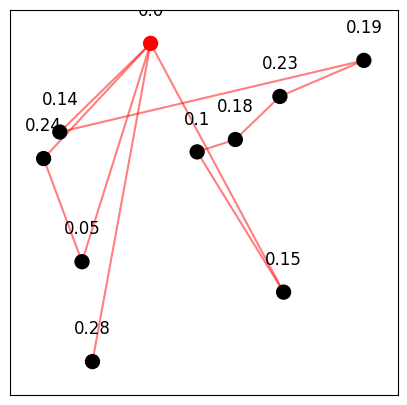

In [58]:
test_env.render()
print()

<Figure size 640x480 with 0 Axes>

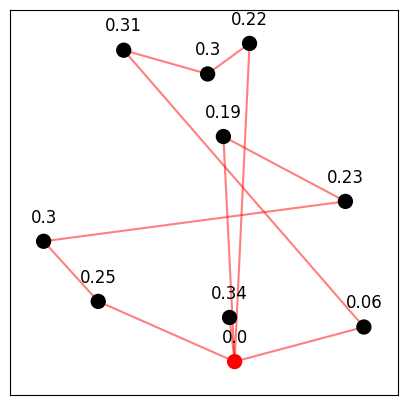

In [50]:
env_irp.render()
print()